# Sprint ディープラーニングフレームワーク1

In [54]:
!pip install --upgrade tensorflow==1.15.0

Requirement already up-to-date: tensorflow==1.15.0 in /usr/local/lib/python3.7/dist-packages (1.15.0)


【問題1】スクラッチを振り返る<br>
・重みの初期化が必要だった<br>
・エポックループが必要だった<br>
・層の構築が必要だった<br>
・各関数において、forward, backward構築が必要だった<br>
・最適化手法を用意して重みを更新する必要があった<br>

# データセットの用意

In [55]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
iris = load_iris()
data = iris.data
label = iris.target
target_name = iris.target_names
all_data = np.concatenate([data, label.reshape(-1, 1)], axis=1)
print(target_name)

train_df = pd.DataFrame(all_data)
train = train_df.iloc[50:, :]
train.rename(columns={0:'SepalLengthCm', 1:'SepalWidthCm', 2:'PetalLengthCm', 3:'PetalWidthCm', 4:'Species'}, inplace=True)
train['Species'].replace(1.0, 'Iris-versicolor', inplace=True)
train['Species'].replace(2.0, 'Iris-virginica', inplace=True)
train

['setosa' 'versicolor' 'virginica']


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
50,7.0,3.2,4.7,1.4,Iris-versicolor
51,6.4,3.2,4.5,1.5,Iris-versicolor
52,6.9,3.1,4.9,1.5,Iris-versicolor
53,5.5,2.3,4.0,1.3,Iris-versicolor
54,6.5,2.8,4.6,1.5,Iris-versicolor
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


【問題2】スクラッチとTensorFlowの対応を考える<br>
・重みの初期化が必要だった<br>
→重みの初期化は変わらず必要である。TensorFlowでは、パラメータとして設定する形になっている<br>
・エポックループが必要だった<br>
→エポックループも変わらずに必要。ここはスクラッチ実装と大きく変わらない<br>
・層の構築が必要だった<br>
→ここも必要ではあるが、スクラッチ実装よりも手軽に層の追加・編集がLayer.add機能で行えるようになっている。<br>
・各関数において、forward, backward構築が必要だった<br>
→一度Layer.addで任意の層を構築すると、実行時に自動的に順伝搬・逆伝搬で学習が行われるようになっている。<br>
・最適化手法を用意して重みを更新する必要があった<br>
→最適化手法が用意されており、その範囲のものを使う分には、スクラッチで実装する必要がなくなっている。<br>

In [56]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
# データセットの読み込み
# df = pd.read_csv("Iris.csv")
df = train
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor") | (df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
# NumPy 配列に変換
X = np.array(X)
y = np.array(y)
# ラベルを数値に変換
y[y == "Iris-versicolor"] = 0
y[y == "Iris-virginica"] = 1
y = y.astype(np.int64)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 100
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    tf.random.set_random_seed(0)
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output
# ネットワーク構造の読み込み                               
logits = example_net(X)
# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# 推定結果
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# variableの初期化
init = tf.global_variables_initializer()

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int64)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
        total_loss /= n_samples
        val_loss, acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}".format(epoch, total_loss, val_loss, acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 1.1500, val_loss : 14.0215, acc : 0.500
Epoch 1, loss : 0.8897, val_loss : 13.5411, acc : 0.500
Epoch 2, loss : 0.7888, val_loss : 11.8243, acc : 0.500
Epoch 3, loss : 0.6679, val_loss : 10.8418, acc : 0.562
Epoch 4, loss : 0.5637, val_loss : 10.3330, acc : 0.500
Epoch 5, loss : 0.5236, val_loss : 9.7076, acc : 0.500
Epoch 6, loss : 0.4900, val_loss : 8.9683, acc : 0.562
Epoch 7, loss : 0.4322, val_loss : 8.4181, acc : 0.500
Epoch 8, loss : 0.3955, val_loss : 7.9386, acc : 0.562
Epoch 9, loss : 0.3678, val_loss : 7.5476, acc : 0.562
Epoch 10, loss : 0.3364, val_loss : 7.1723, acc : 0.562
Epoch 11, loss : 0.3149, val_loss : 6.8348, acc : 0.625
Epoch 12, loss : 0.2963, val_loss : 6.5382, acc : 0.625
Epoch 13, loss : 0.2774, val_loss : 6.2857, acc : 0.625
Epoch 14, loss : 0.2615, val_loss : 6.0683, acc : 0.625
Epoch 15, loss : 0.2467, val_loss : 5.8699, acc : 0.625
Epoch 16, loss : 0.2322, val_loss : 5.6911, acc : 0.688
Epoch 17, loss : 0.2193, val_loss : 5.5466, acc : 0.6

【問題3】3種類全ての目的変数を使用したIrisのモデルを作成<br>
参考サイト：<br>
https://qiita.com/raso0527/items/4d0f77e816506511469e<br>

In [57]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
iris = load_iris()
data = iris.data
label = iris.target
target_name = iris.target_names
all_data = np.concatenate([data, label.reshape(-1, 1)], axis=1)
print(target_name)

train_df = pd.DataFrame(all_data)
train = train_df.iloc[:, :]
train.rename(columns={0:'SepalLengthCm', 1:'SepalWidthCm', 2:'PetalLengthCm', 3:'PetalWidthCm', 4:'Species'}, inplace=True)
train['Species'].replace(0.0, 'Iris-setosa', inplace=True)
train['Species'].replace(1.0, 'Iris-versicolor', inplace=True)
train['Species'].replace(2.0, 'Iris-virginica', inplace=True)
train

['setosa' 'versicolor' 'virginica']


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Step #25 A = [[-0.78342134  0.8736729  -0.5325851 ]
 [-1.5571024  -0.4969507  -0.3290635 ]
 [-0.4178735  -0.6904336   0.68340737]
 [ 0.70635015 -1.0762354  -0.0974121 ]] b = [-0.36178365 -0.01402414  0.9880354 ]
Loss = 0.9464664
Acc = 0.6933333
Step #50 A = [[-0.09919751  0.79855895 -0.5832068 ]
 [-1.0906407  -0.6343527  -0.3764728 ]
 [-0.22048712 -0.5398163   0.7340515 ]
 [ 0.73809606 -1.0111351  -0.05770323]] b = [-0.22479635 -0.03999507  0.96858984]
Loss = 1.1774287
Acc = 0.52
Step #75 A = [[ 0.2666577   0.7643704  -0.61555797]
 [-0.7654588  -0.74460196 -0.41153285]
 [-0.2580504  -0.3892211   0.78502643]
 [ 0.69063014 -0.95032966 -0.01910936]] b = [-0.14069709 -0.05603657  0.9532858 ]
Loss = 0.69478285
Acc = 0.6
Step #100 A = [[ 0.33758342  0.72478557 -0.63883626]
 [-0.6129086  -0.8355862  -0.4363882 ]
 [-0.46470428 -0.27934572  0.84013873]
 [ 0.58977354 -0.9075305   0.02295065]] b = [-0.10891949 -0.06990606  0.9397919 ]
Loss = 0.5984309
Acc = 0.6
Step #125 A = [[ 0.39515626  0.6833

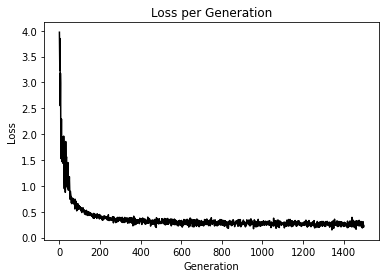

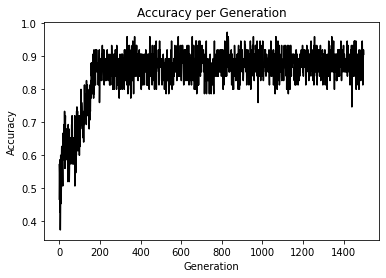

In [58]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn import datasets

# シード値を固定して実行の度に同じ乱数が発生するようにしている
tf.set_random_seed(1000)
np.random.seed(1000)
sess = tf.Session()

# setosa, versicolor, virginicaの分類を行う

iris = datasets.load_iris()
x_vals = iris.data
target = iris.target

# ワンホットベクトルの作成
y1 = [[1, 0, 0] for i in target if i == 0]
y2 = [[0, 1, 0] for i in target if i == 1]
y3 = [[0, 0, 1] for i in target if i == 2]

y_vals = np.array(y1+y2+y3)

learning_rate = 0.05
batch_size = 25

x_data = tf.placeholder(shape = [None, 4], dtype = tf.float32)
y_target = tf.placeholder(shape = [None, 3], dtype = tf.float32)

A = tf.Variable(tf.random_normal(shape = [4, 3]))
b = tf.Variable(tf.random_normal(shape = [3]))

model_output = tf.add(tf.matmul(x_data, A), b)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = model_output, labels = y_target))
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = model_output, labels = y_target))

init = tf.global_variables_initializer()
sess.run(init)

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(loss)

prediction = tf.round(tf.sigmoid(model_output))
prediction_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(prediction_correct)

loss_vec = []
accuracy_vec = []

for i in range(1500):

    rand_index = np.random.choice(len(x_vals), size = batch_size)
    rand_x = x_vals[rand_index]
    rand_y = y_vals[rand_index]

    sess.run(train, feed_dict = {x_data: rand_x, y_target: rand_y})

    tmp_accuracy, temp_loss = sess.run([accuracy, loss], feed_dict = {x_data: rand_x, y_target: rand_y})

    loss_vec.append(temp_loss)
    accuracy_vec.append(tmp_accuracy)

    if (i + 1) % 25 == 0:

        print("Step #" + str(i + 1) + " A = " + str(sess.run(A)) + " b = " + str(sess.run(b)))
        print("Loss = " + str(temp_loss))
        print("Acc = " + str(tmp_accuracy))

plt.plot(loss_vec, "k-")
plt.title("Loss per Generation")
plt.xlabel("Generation")
plt.ylabel("Loss")
plt.show()

plt.plot(accuracy_vec, "k-")
plt.title("Accuracy per Generation")
plt.xlabel("Generation")
plt.ylabel("Accuracy")
plt.show()

【問題4】House Pricesのモデルを作成<br>
参考サイト：<br>
https://www.tensorflow.org/tutorials/keras/regression?hl=ja<br>
https://qiita.com/SwitchBlade/items/6677c283b2402d060cd0<br>

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
DIR_PATH = '/content/drive/My Drive/Colab Notebooks/house-prices-advanced-regression-techniques/'
train = pd.read_csv(DIR_PATH+'train.csv')
test = pd.read_csv(DIR_PATH+'test.csv')
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,G

In [61]:
X = train[['GrLivArea', 'YearBuilt']]
y = train[['SalePrice']]
x_test = test[['GrLivArea', 'YearBuilt']]

In [67]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# データフレームから条件抽出
X = train[['GrLivArea', 'YearBuilt', 'SalePrice']]

train_dataset = X.sample(frac=0.8,random_state=0)
test_dataset = X.drop(train_dataset.index)

train_labels = train_dataset.pop('SalePrice')
test_labels = test_dataset.pop('SalePrice')

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [68]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,3.333751e+09,39201.402344,3.333751e+09,3.063479e+09,38262.617188,3.063479e+09,995
996,3.319546e+09,39059.910156,3.319546e+09,3.107206e+09,39441.765625,3.107206e+09,996
997,3.324858e+09,39170.570312,3.324858e+09,3.066965e+09,38631.125000,3.066965e+09,997
998,3.330439e+09,39202.699219,3.330440e+09,3.062772e+09,38374.554688,3.062772e+09,998
999,3.323166e+09,39040.640625,3.323166e+09,3.061470e+09,38500.285156,3.061469e+09,999


In [70]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

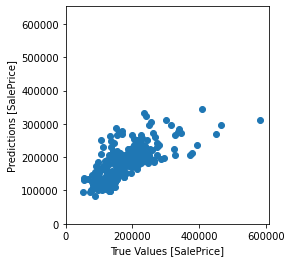

In [72]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [SalePrice]')
plt.ylabel('Predictions [SalePrice]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [74]:
error = test_predictions - test_labels
print(f'予測した結果と正解データとのの誤差: {np.sum(error)}')

予測した結果と正解データとのの誤差: 1840203.4765625


【問題5】MNISTのモデルを作成

In [75]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [76]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [80]:
predictions = model(x_train[:1])
predictions

<tf.Tensor 'sequential_4_2/dense_13/BiasAdd:0' shape=(1, 10) dtype=float32>

In [82]:
tf.nn.softmax(predictions)

<tf.Tensor 'Softmax_1:0' shape=(1, 10) dtype=float32>

In [84]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn

In [85]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 100us/sample - loss: 0.2955 - acc: 0.9146
Epoch 2/5
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1455 - acc: 0.9568
Epoch 3/5
60000/60000 [==============================] - 6s 97us/sample - loss: 0.1067 - acc: 0.9677
Epoch 4/5
60000/60000 [==============================] - 6s 95us/sample - loss: 0.0887 - acc: 0.9721
Epoch 5/5
60000/60000 [==============================] - 6s 96us/sample - loss: 0.0743 - acc: 0.9766


In [86]:
model.evaluate(x_test,  y_test, verbose=2)

10000/10000 - 0s - loss: 0.0816 - acc: 0.9764


[0.08164553142033983, 0.9764]

In [90]:
# モデルが確率を返すようにする
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])
probability_model(x_test[:5])

<tf.Tensor 'sequential_8/softmax_3/Softmax:0' shape=(5, 10) dtype=float32>

### 後で熟読して1系→2系への書き換えに挑む
https://www.tensorflow.org/guide/migrate<br>